In [59]:
import numpy as np
import matplotlib.pyplot as plt
import os
from glob import glob
import re

comprendre comment on passe des positions aux fréquences sans convertir les positions en pixels????

In [60]:
# Charger les fichiers de positions. Puis 1) les nettoyer. 2) Convertir en fréquences. 3) resynchroniser avec le son.

In [61]:
class Mapping(object):
    """
    
    """
    def __init__(self, width, n_freq, mid, octave):
        """
        Construction d'un objet de Mapping.
        :param width: Largeur de l'image en pixels. 
        :param n_freq: Nombre de fréquences.
        :param mid: Fréquence du milieu.
        :param octave: Nombre d'octaves.
        """
        self.bandwidth = width / (n_freq - 1)
        self.half_bandwidth = self.bandwidth // 2
        self.width = width
        self.mid = mid
        self.o = octave
        self.m_numFrequency = n_freq
        self._lut_indices = np.zeros(self.width, dtype=int)
        self.tones = np.zeros(n_freq)
        self._lut_tones = np.zeros(self.width)
        self._build_lut()

    def _build_lut(self):
        """
        Construit la "look-up table" des indices du mapping et également la LUT des fréquences.
        """
        
        def mapping(mid, n, o):
            _t = np.zeros(n)
            m_idx = n // 2
            _t[m_idx] = 0
            s = o / n
            _t[:m_idx] = np.arange((- n // 2) + 1, 0)
            _t[m_idx + 1:] = np.arange(1, n // 2 + 1)
            _t = np.round(mid * np.power(2, _t * s))
            return _t
        
        def func(position):
            if position < self.half_bandwidth:
                index = 0
            elif position > (self.width - self.half_bandwidth):
                index = self.m_numFrequency - 1
            else:
                index = position - self.half_bandwidth
                index //= self.bandwidth
                index += 1
            return int(index)
        
        def func_fill_tones(position, tones):
            return tones[func(position)]
        
        self.tones = mapping(self.mid, self.m_numFrequency, 7.0)
        for i in range(self.width):
            self._lut_indices[i] = func(i)
            self._lut_tones[i] = func_fill_tones(i, self.tones)
            

    def get_start_stop(self, motion):
        """
        Renvoie les indices de départ et d'arrivée pour un mouvement donnée.
        """
        start = self._lut_indices[motion[0]]
        stop = self._lut_indices[motion[1]]
        return start, stop
    
    def convert_position(self, x):
        if not np.isnan(x) and x != -1:
            return self._lut_tones[int(x)]
        else:
            return -1
    
    def convert_to_frequency(self, motion):
        """
        Renvoie les fréquences correspondantes aux positions dans un vecteur.
        :param motion: 
        :return: 
        """
        t = np.zeros(len(motion), dtype=float)
        for i, _p in enumerate(motion):
            if not np.isnan(_p):
                t[i] = self._lut_tones[int(_p)]
            else:
                t[i] = np.nan
        return t

In [62]:
def clean_positions(positions):
    """
    Fonction de nettoyage des positions enregistrées au cours de l'expérience. Pour rappel, une valeur de -1, indique que le sujet n'a pas été détecté par le réseau de neurones.
    :param positions: 
    :return: 
    """
    y = np.where(positions == -1)[0]
    diff_y = np.diff(y)
    diff_y = np.vstack((np.arange(1, len(diff_y) + 1), diff_y)).T
    k = 0
    begin = 0
    for i, elt in diff_y:
        if elt != 1:
            positions[y[i - 1]] = positions[y[i - 1] + 1]
            positions[y[i]] = positions[y[i] - 1]
            if k != 0:
                end = y[i - 1]
                filler = np.full(shape=k, fill_value=positions[begin - 1])
                positions[begin:end] = filler
                k = 0
        else:
            if k == 0:
                begin = y[i - 1]
            k += 1
    remainder = np.where(positions == -1)[0]
    if len(remainder) != 0 and k != 0:
        pass

    return positions


def stack_positions_data(positions_files):
    """
    Retourne les vecteurs continus, et un np.ndarray des positons où il faudra recouper pour séparer à nouveau.
    :param positions_files: 
    :return: 
    """
    # Ici, il va falloir garder en mémoire la dimension exacte de chaque sous tableau.
    split_mem = np.zeros(len(positions_files) - 1, dtype=int)
    is_playback = list()
    playback_pattern = "positions_Playback_playback_0[0-9]"
    positions_vectors = list()
    start = 0
    for i, file in enumerate(positions_files):
        # Je connais les indices où sont les positions de playback.
        if re.search(playback_pattern, file):
            is_playback.append(i)
        vec = np.fromfile(file, dtype=np.int32)
        if i != (len(positions_files) - 1):
            start += len(vec)
            split_mem[i] = start
        positions_vectors.append(vec)
    cp = clean_positions(np.hstack(positions_vectors))
    cp = np.split(cp, split_mem)
    playback_positions_list = [cp[i] for i in is_playback]
    print(is_playback)
    return playback_positions_list


def stack_positions_data_tracking(positions_files):
    """
    Retourne les vecteurs continus, et un np.ndarray des positons où il faudra recouper pour séparer à nouveau.
    :param positions_files: 
    :return: 
    """
    # Ici, il va falloir garder en mémoire la dimension exacte de chaque sous tableau.
    split_mem = np.zeros(len(positions_files) - 1, dtype=int)
    is_playback = list()
    playback_pattern = "positions_Playback_tracking_0[0-9]"
    positions_vectors = list()
    start = 0
    for i, file in enumerate(positions_files):
        # Je connais les indices où sont les positions de playback.
        if re.search(playback_pattern, file):
            is_playback.append(i)
        vec = np.fromfile(file, dtype=np.int32)
        if i != (len(positions_files) - 1):
            start += len(vec)
            split_mem[i] = start
        positions_vectors.append(vec)
    # print(is_playback)
    cp = clean_positions(np.hstack(positions_vectors))
    cp = np.split(cp, split_mem)
    playback_positions_list = [cp[i] for i in is_playback]
    print(is_playback)
    return playback_positions_list
    
    
def detect_frequency_switch(vec, mapping):
    """
    Fonction qui a pour objectif de détecter les changements de fréquences.
    :param mapping:
    :param vec: 
    :return: 
    """
    # print(np.unique(vec))
    tone_vec = mapping.convert_to_frequency(vec)
    d = np.diff(tone_vec)
    idx = np.where(d != 0)[0] + 1
    switch = tone_vec[idx]
    return switch


def load_mock_tones_files(folder):
    return _load_tones(folder, "mock")


def load_playback_tones_files(folder):
    return _load_tones(folder, "playback")


def load_tracking_tones_files(folder):
    return _load_tones(folder, "tracking")


def load_warmup_tones_files(folder):
    return _load_tones(folder, "warmup")


def _load_tones(folder, type_of):
    glob_files = glob(os.path.join(folder, "tones", "*.bin"))
    #pattern = f"{type_of}_0[0-9]"
    pattern = f"{type_of}_0[0-5]_*_*_*_*"
    clean_files = list()
    print(glob_files)
    for file in glob_files:
        if re.search(pattern, file):
            clean_files.append(file)
    files = ["" for _ in clean_files]
    for file in clean_files:
        match = re.search(rf'{type_of}_(\d+)', file)
        if match:
            value = int(match.group(1))
            p = np.fromfile(file, dtype=float)
            files[value] = p
    return files


def load_positions_file(folder):
    """
    Retourne une liste avec les fichiers des positions enregistrées au cours de l'expérience ordonnés.
    :param folder: Dossier de sauvegarde de l'expérience.
    :return: Une liste avec les noms de fichiers dans l'ordre chronologique.
    """
    # Pipeline : extraire tous les fichiers, les remettre dans l'ordre. Nettoyer, couper.
    # Extraire les fréquences du Mock.
    # Comparer la longueur, une fois les changements détectés. OK.
    pause_pattern = "positions_Pause_0[0-9]"
    playback_pattern = "positions_playback_0[0-9]"
    tracking_pattern = "positions_tracking_0[0-9]"
    warmup_pattern = "positions_tail_0[0-9]"

    glob_files = glob(os.path.join(folder, "positions", "positions_*.bin"))
    types_pos_list = [list() for _ in range(4)]
    for file in glob_files:
        if re.search(pause_pattern, file):
            types_pos_list[0].append(file)
        elif re.search(warmup_pattern, file):
            types_pos_list[1].append(file)
        elif re.search(tracking_pattern, file):
            types_pos_list[2].append(file)
        elif re.search(playback_pattern, file):
            types_pos_list[3].append(file)
    
    out = ["" for _ in glob_files]
    
    for file_name in types_pos_list[0]:
        match = re.search(r'positions_Pause_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[0] = file_name
            else:
                out[-1] = file_name
                
    for file_name in types_pos_list[1]:
        match = re.search(r'positions_Playback_warmup_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[1] = file_name
            else:
                out[-2] = file_name
    idx = 2
    n_iter = len(types_pos_list[2])
    
    for i in range(n_iter):
        file_name = types_pos_list[2][i]
        match = re.search(r'positions_Playback_tracking_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            out[idx + value * 2] = file_name
        
        file_name = types_pos_list[3][i]
        match = re.search(r'positions_Playback_playback_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            out[idx + value * 2 + 1] = file_name
    return out


def test(folder):
    o = load_positions_file(folder)
    split_mem = np.zeros(len(o) - 1, dtype=int)
    positions_vectors = list()
    start = 0
    for i, file in enumerate(b):
        # Je connais les indices où sont les positions de playback.
        vec = np.fromfile(file, dtype=np.int32)
        if i != (len(o) - 1):
            start += len(vec)
            split_mem[i] = start
        positions_vectors.append(vec)
    cp = np.hstack(positions_vectors)
    cp = np.split(cp, split_mem)
    print(f"Length : {len(cp)}, {len(o)}, {len(positions_vectors)}")
    for i in range(len(cp)):
        print(len(cp[i]) == len(positions_vectors[i]))
    for i in range(len(cp)):
        print(cp[i] == positions_vectors[i])
        
    return 

In [63]:
def _load_tones(folder, type_of):
    glob_files = glob(os.path.join(folder, "tones", "*.bin"))
    #pattern = f"{type_of}_0[0-9]"
    pattern = f"{type_of}_0[0-5]_*_*_*_*"
    clean_files = list()
    print(glob_files)
    for file in glob_files:
        if re.search(pattern, file):
            clean_files.append(file)
    files = ["" for _ in clean_files]
    return clean_files

In [64]:
def load_positions_file(folder):
    """
    Retourne une liste avec les fichiers des positions enregistrées au cours de l'expérience ordonnés.
    :param folder: Dossier de sauvegarde de l'expérience.
    :return: Une liste avec les noms de fichiers dans l'ordre chronologique.
    """
    # Pipeline : extraire tous les fichiers, les remettre dans l'ordre. Nettoyer, couper.
    # Extraire les fréquences du Mock.
    # Comparer la longueur, une fois les changements détectés. OK.
    pause_pattern = "positions_Pause_0[0-9]"
    playback_pattern = "positions_playback_0[0-9]"
    tracking_pattern = "positions_tracking_0[0-9]"
    warmup_pattern = "positions_tail_0[0-9]"

    glob_files = glob(os.path.join(folder, "positions", "positions_*.bin"))
    print(glob_files)
    types_pos_list = [list() for _ in range(4)]
    for file in glob_files:
        if re.search(pause_pattern, file):
            types_pos_list[0].append(file)
        elif re.search(warmup_pattern, file):
            types_pos_list[1].append(file)
        elif re.search(tracking_pattern, file):
            types_pos_list[2].append(file)
        elif re.search(playback_pattern, file):
            types_pos_list[3].append(file)
    
    out = ["" for _ in glob_files]
    print(types_pos_list)
    
    for file_name in types_pos_list[0]:
        match = re.search(r'positions_Pause_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[0] = file_name
            else:
                out[-1] = file_name
                
    for file_name in types_pos_list[1]:
        match = re.search(r'positions_tail_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            if value == 0:
                out[1] = file_name
            else:
                out[-2] = file_name
    idx = 2
    n_iter = len(types_pos_list[2])
    
    for i in range(n_iter):
        file_name = types_pos_list[2][i]
        match = re.search(r'positions_tracking_(\d+)', file_name)
        if match:
            value = int(match.group(1))
            out[idx + value * 2] = file_name
        
        file_name = types_pos_list[3][i]
        match = re.search(r'positions_playback_(\d+)', file_name)
        print(match)
        if match:
            print('yes')
            value = int(match.group(1))
            print(idx + value * 2 + 1)
            out[idx + value * 2 + 1] = file_name
    return out, types_pos_list

In [65]:
def find_playback_files(folder):
    # Define the pattern to search for in the filenames
    playback_pattern = re.compile(r'positions_playback_')

    # Initialize an empty list to store the names of matching files
    playback_files = []

    # Walk through the directory
    for root, dirs, files in os.walk(os.path.join(folder, "positions")):
        for file in files:
            if playback_pattern.search(file):
                playback_files.append(file)

    return playback_files

In [66]:
def find_mock_tones_files(folder):
    # Define the pattern to search for in the filenames
    mock_pattern = re.compile(r'tones_mock_')

    # Initialize an empty list to store the names of matching files
    mock_files = []

    # Walk through the directory
    for root, dirs, files in os.walk(os.path.join(folder, "tones")):
        for file in files:
            if mock_pattern.search(file):
                mock_files.append(file)

    return mock_files

In [67]:

# Define the folder path
folder = "/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00"

# Find and print the playback files
pb_positions = find_playback_files(folder)

In [68]:
pb_tones = load_playback_tones_files(folder)

['/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_playback_04_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_tracking_01_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_mock_04_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_playback_02_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_tracking_06_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_tail_00_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/

In [82]:
def load_bin_data(file_path, dtype=np.float32):
    # Load binary data from the file
    return np.fromfile(file_path, dtype=dtype)

def create_large_matrix(path):
    # Find playback files
    playback_files = find_playback_files(path)
    print(playback_files)
    
    # Initialize an empty list to collect data arrays
    data_list = []

    # Load data from each file and append it to the list
    for file in playback_files:
        data = load_bin_data(path+'/positions/'+file)
        data_list.append(data)

    return data_list

In [70]:
test_mock = load_bin_data("/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/FRINAULT/FRINAULT_20230223/positions/positions_Playback_tracking_07_FRINAULT_20230223_SESSION_00.bin")

In [71]:
t = test_mock*10e43
print(np.nanmin(t),np.nanmax(t))

30.26804682941605 210.75528903445252


In [84]:
mapping = Mapping(1920, 33, 2000., 7)
    # print(np.unique(vec))
print(pb_positions[3])
vec = load_bin_data(folder+'/positions/'+pb_positions[3], dtype=np.int32)
tone_vec = mapping.convert_to_frequency(vec)
d = np.diff(tone_vec)
idx = np.where(d != 0)[0] + 1
switch = tone_vec[idx]
print(switch)
print(tone_vec)


positions_playback_03_BURRATA_SESSION_00_20240430.bin
[1287.  959. 1287. ... 1287.  828. 1287.]
[ 959. 1287.  959. ... 1287.  828. 1287.]


In [85]:
np.unique(tone_vec, return_counts=True)

(array([  190.,   220.,   255.,   296.,   343.,   397.,   460.,   533.,
          617.,   715.,   828.,   959.,  1111.,  1287.,  1490.,  1727.,
         2000.,  2317.,  2684.,  3109.,  3601.,  4172.,  4832.,  5598.,
         6484.,  7511.,  8701., 10079., 11676., 18149., 21024.]),
 array([   46,   128,   159,   198,   228,   429,   634,  2201,  8036,
         5693,  2497,  2327,  5263, 17106, 20852,  4358,  2295,  1296,
          718,   815,   528,   716,   824,   766,   733,  3973,  3081,
         2609,    68,    31,  7378]))

In [74]:
mapping = Mapping(1920, 33, 2000., 7)

def detect_frequency_switch(vec, mapping):
    """
    Fonction qui a pour objectif de détecter les changements de fréquences.
    :param mapping:
    :param vec:
    :return:
    """
    # Je convertis le vecteur de positions en fréquences.
    tone_vec = mapping.convert_to_frequency(vec)
    d = np.diff(tone_vec)
    # Je repère les moments où les fréquences changent.
    idx = np.where(d != 0)[0] + 1
    
    # Je retourne un array de fréquences.
    switch = tone_vec[idx]
    return switch, idx

In [75]:
switch, idx = detect_frequency_switch([0,2, 45, 12, 57, 1789, 1919, 1245, 1233, 560, 1290], mapping)

In [76]:
print(switch)
print(idx)

[  220.   190.   220. 15667. 21024.  4172.   715.  4832.]
[ 2  3  4  5  6  7  9 10]


In [77]:
print(np.nanmin(vec), np.nanmax(vec))

0.0 2.322e-42


In [78]:
mck_tones_files = find_mock_tones_files(folder)
print(mck_tones_files)
tones = load_bin_data(folder+'/tones/'+mck_tones_files[-1], dtype=np.float32)

['tones_mock_04_BURRATA_SESSION_00_20240430.bin', 'tones_mock_02_BURRATA_SESSION_00_20240430.bin', 'tones_mock_05_BURRATA_SESSION_00_20240430.bin', 'tones_mock_01_BURRATA_SESSION_00_20240430.bin', 'tones_mock_03_BURRATA_SESSION_00_20240430.bin']


8
2518


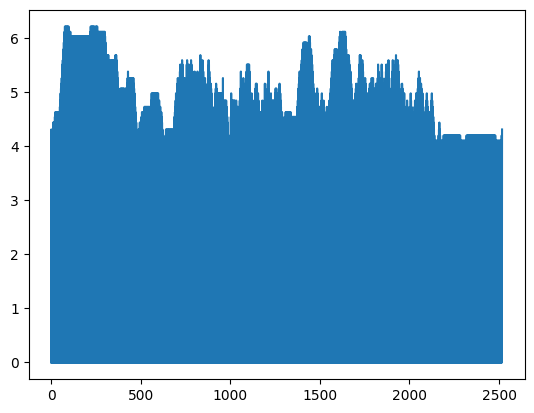

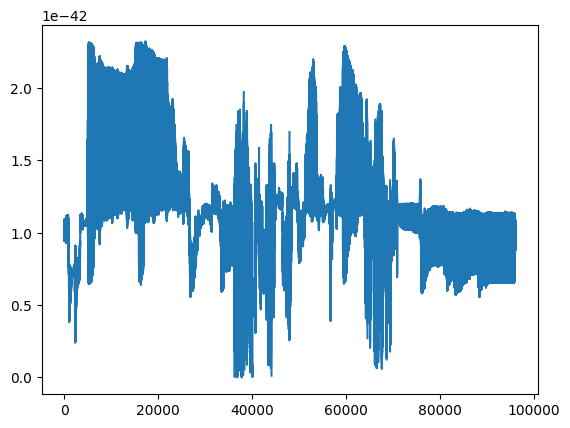

nombre de switch, 8


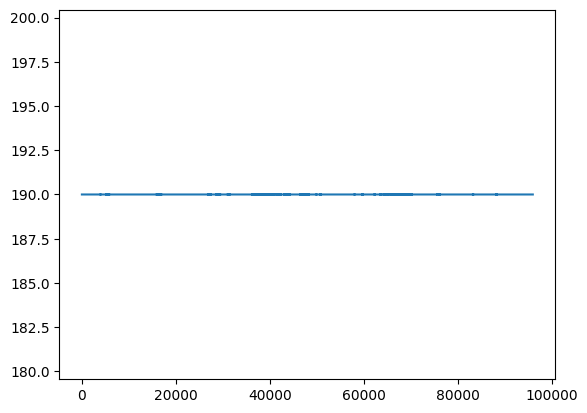

In [79]:
print(len(switch))
print(len(tones))
plt.plot(tones)
plt.show()
plt.plot(vec)
plt.show()
plt.plot(tone_vec)
print( 'nombre de switch,',np.sum(~np.isnan(switch)))

In [80]:
def frequency_correction(folder):
    # C'est tout le pipeline de correction des fréquences.
    # 0. Créer le mapping
    mapping = Mapping(1920, 33, 2000., 7)
    # 1. Charger les "mock tones".
    #mock_tones = load_mock_tones_files(folder)
    pb_tones = load_playback_tones_files(folder)
    tr_tones = load_tracking_tones_files(folder)
    positions = load_positions_file(folder)
    clean_pb_pos = stack_positions_data(positions)
    mock_corrected = [detect_frequency_switch(vec, mapping) for vec in clean_pb_pos]
    return positions, clean_pb_pos, mock_corrected, pb_tones, tr_tones

In [81]:
a, b, c, e, g = frequency_correction("/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/")

['/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_playback_04_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_tracking_01_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_mock_04_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_playback_02_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_tracking_06_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/tones/tones_tail_00_BURRATA_SESSION_00_20240430.bin', '/mnt/working2/felicie/Python_theremin/Analyse/

IndexError: list assignment index out of range

In [ ]:
for elt in range(len(a)):
    print(len(a[elt]), len(e[elt]))
    
# plt.plot(a[0])
tt = np.arange(len(g[0]) + len(e[0]) + len(g[1]) + len(e[1]))

plt.plot(tt[:len(g[0])], g[0])
_sum = len(g[0]) + len(e[0])
plt.plot(tt[len(g[0]): _sum], e[0])

plt.plot(tt[_sum:_sum + len(g[1])], g[1])
_sum += len(g[1])
plt.plot(tt[_sum:], e[1])

In [ ]:
for l in range(len(a)):
    plt.plot(a[l] + 10000)
    plt.plot(e[l])
    plt.plot(g[l])
    plt.show()

In [ ]:
mck_total = np.hstack(a)
pb_total = np.hstack(g)
m = Mapping(1920, 33, 2000., 7)
un, counts = np.unique(mck_total, return_counts=True)
un_pb, counts_pb = np.unique(pb_total, return_counts=True)

fig, ax = plt.subplots(2, 1)
# h, _ = np.histogram(mck_total, m._lut_tones)
ax[0].bar(np.log2(un), counts)
ax[1].bar(np.log2(un_pb), counts_pb)
# plt.xticks()

In [ ]:
def frequency_correction_2(folder):
    # C'est tout le pipeline de correction des fréquences.
    # 0. Créer le mapping
    mapping = Mapping(1920, 33, 2000., 7)
    # 1. Charger les "mock tones".
    mock_tones = load_mock_tones_files(folder)
    pb_tones = load_playback_tones_files(folder)
    tr_tones = load_tracking_tones_files(folder)
    positions = load_positions_file(folder)
    clean_pb_pos = stack_positions_data(positions)
    clean_tr_pos = stack_positions_data_tracking(positions)
    mock_corrected = [detect_frequency_switch(vec, mapping) for vec in clean_pb_pos]
    tr_test = [detect_frequency_switch(vec, mapping) for vec in clean_tr_pos]
    return clean_pb_pos, clean_tr_pos, mock_corrected, tr_test, pb_tones, tr_tones, positions

In [ ]:
p_tr = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/positions/positions_tracking_03_BURRATA_SESSION_00_20240430.bin'
p_pb= '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00/positions/positions_playback_03_BURRATA_SESSION_00_20240430.bin'
def frequency_correction_block(folder):
    # C'est tout le pipeline de correction des fréquences.
    # 0. Créer le mapping
    mapping = Mapping(1920, 33, 2000., 7)
    # 1. Charger les "mock tones".
    pb_tones = load_playback_tones_files(folder)
    tr_tones = load_tracking_tones_files(folder)
    positions = load_positions_file(folder)
    clean_pb_pos = np.load()
    clean_tr_pos = stack_positions_data_tracking(positions)
    mock_corrected = [detect_frequency_switch(vec, mapping) for vec in clean_pb_pos]
    tr_test = [detect_frequency_switch(vec, mapping) for vec in clean_tr_pos]
    return clean_pb_pos, clean_tr_pos, mock_corrected, tr_test, pb_tones, tr_tones, positions

In [ ]:
folder = '/mnt/working2/felicie/Python_theremin/Analyse/Analyse/Experiment/BURRATA/BURRATA_20240430_SESSION_00'
frequency_correction_block(folder)

In [ ]:
a = load_tracking_tones_files("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")
b = load_playback_tones_files("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")

In [ ]:
plt.plot(g[0])
plt.plot(h[0])

In [ ]:
len(b)

In [ ]:
a, b, c, e, g, h, q = frequency_correction_2("/Users/flavienferal/data/EXPERIMENT/MUROLS/MUROLS_20230218/MUROLS_20230218_SESSION_01")

In [ ]:
plt.plot(h[0])
# plt.plot(g[0])
plt.plot(e[0])

In [ ]:
tt = np.arange(len(b[0]) + len(a[0]) + len(b[1]) + len(a[1]))
plt.plot(tt[:len(b[0])], b[0])
_sum = len(b[0]) + len(a[0])
plt.plot(tt[len(b[0]): _sum], a[0])

plt.plot(tt[_sum:_sum + len(b[0])], b[1])
_sum += len(b[1])
plt.plot(tt[_sum:], a[1])



In [ ]:
rr = np.fromfile(q[2], dtype=np.int32)
plt.plot(rr)
plt.plot(b[0])

In [ ]:
m = Mapping(1920, 33, 2000., 7)
tv = m.convert_to_frequency(b[0].astype(int))

In [ ]:
plt.plot(tv)
diff = np.diff(tv)
_i = np.where(diff != 0)[0] + 1
print(len(_i))
print(len(e[0]))
print(len(h[0]))
plt.scatter(_i, tv[_i], c="r")

In [ ]:
rr = np.fromfile(q[2], dtype=np.int32)
rr = rr.astype(float)
rr[np.equal(rr, -1)] = np.nan
# rr[rr == -1] = np.nan

tv = m.convert_to_frequency(rr)
plt.plot(tv)

In [ ]:
def find_frequency_changes_with_nan(arr):
    _diff = np.diff(arr)
    condition = (~np.isnan(_diff)) & (_diff != 0)
    indices = np.where(condition)[0] + 1
    return arr[indices]

In [ ]:
rr_switch = find_frequency_changes_with_nan(tv)

In [ ]:
np.diff(tv)

In [ ]:
rr_switch


In [ ]:
plt.plot(rr_switch)
plt.plot(h[0])

In [ ]:
len(rr_switch)


In [ ]:
len(b[0])

In [ ]:
len(h[0])

In [ ]:
current_frequency = 533.0
sw = list()
for elt in rr:
    f = m.convert_position(elt)
    if f != current_frequency and f != -1:
        current_frequency = f
        sw.append(current_frequency)

In [ ]:
len(sw)

In [ ]:
len(h[0])

In [ ]:
plt.plot(sw)
plt.plot(h[0])


In [ ]:
sw[0]

In [ ]:
plt.plot(m._lut_indices)

In [ ]:
np.unique(m._lut_indices, return_counts=True)